# Assignment # 9  
Park Juyeon, Department of Statistics and Data Science, 2022311137

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from factor_analyzer import FactorAnalyzer

pd.options.display.float_format = '{:.5f}'.format
np.set_printoptions(suppress=True)
warnings.filterwarnings(action='ignore')
plt.rcParams['figure.facecolor'] = 'white'

----

# Q1. Write a Python code to implement a Factor analysis with the following features.  
    A. Principal component method on correlation matrix  
    B. Scree plot  
    C. Factor loading matrix  
    D. Communality  

In [2]:
from sklearn.decomposition import PCA
from numpy.linalg import eig
import scipy

class FACTOR_ANALYSIS():
    def __init__(self, df):
        # A. PCA on correlation matrix
        self.df = df
        self.n, self.p = self.df.shape

        ## 1. Calculate correlation matrix
        self.corr = np.array(df.corr())

        ## 2. PCA on corr
        self.eigvals, self.eigvecs = eig(self.corr)
        idx = np.argsort(self.eigvals)[::-1]
        self.eigvals = self.eigvals[idx]
        self.eigvecs = self.eigvecs[:, idx]

        # Proportion of total variance explained by principal components
        self.explained_variance_ratio = self.eigvals / self.p  # corresponds to sklearn.decomposition.PCA.explained_variance_ratio_
        self.cum_explained_variance_ratio = self.explained_variance_ratio.cumsum()  # cummulative sum of proportion of variance
    
    # B. Scree plot
    def screeplot(self):
        plt.plot(self.eigvals, marker='d')
        plt.title('Scree plot', fontsize=15)
        plt.ylabel('Eigenvalue')
        plt.xlabel('Index of Eigvalues')
        plt.show()

    # C. Obtain Factor loading matrix
    def factor_loading(self, m):
        loadings = pd.DataFrame(np.zeros((self.p, m)), columns=[f'Factor{i+1}' for i in range(m)])
        for i in range(m):
            loadings[f'Factor{i+1}'] = np.sqrt(self.eigvals[i]) * self.eigvecs[:, i]
            loadings.index = self.df.columns
            
        return loadings
    
    # D. Communality
    def communality(self, m):
        loadings = self.factor_loading(m)
        loading_sqared = np.power(loadings, 2)
        return np.sum(loading_sqared, axis=1)

---   

# Q2. Apply on the weekly rates of return data for five stocks listed on the New York Stock Exchange are given in 'stock.dat'.

#### Read Stock data 

In [3]:
stock = pd.read_csv('stock.dat', header = None, delim_whitespace = True)
stock.columns = ['Allied Chemical', 'Du Pont', 'Union Carbide', 'Exxon', 'Texaco']
stock.head()

,Allied Chemical,Du Pont,Union Carbide,Exxon,Texaco
0,0.00000,0.00000,0.00000,0.03947,-0.00000
1,0.02703,-0.04485,-0.00303,-0.01447,0.04348
2,0.12281,0.06077,0.08815,0.08624,0.07812
3,0.05703,0.02995,0.06681,0.01351,0.01951
4,0.06367,-0.00379,-0.03979,-0.01864,-0.02415


## A. Perform a factor analysis on the sample correlation matrix

In [4]:
# 1. Factor Analysis
FA = FACTOR_ANALYSIS(stock)

pc_result = pd.DataFrame()
pc_result['Eigvalue'] = FA.eigvals  # 첫번째 eigvalue까지가 적절해보임
pc_result['Proportion'] = FA.explained_variance_ratio
pc_result['Cummulative'] = FA.cum_explained_variance_ratio

pc_result

,Eigvalue,Proportion,Cummulative
0,2.85649,0.57130,0.57130
1,0.80912,0.16182,0.73312
2,0.54004,0.10801,0.84113
3,0.45135,0.09027,0.93140
4,0.34300,0.06860,1.00000


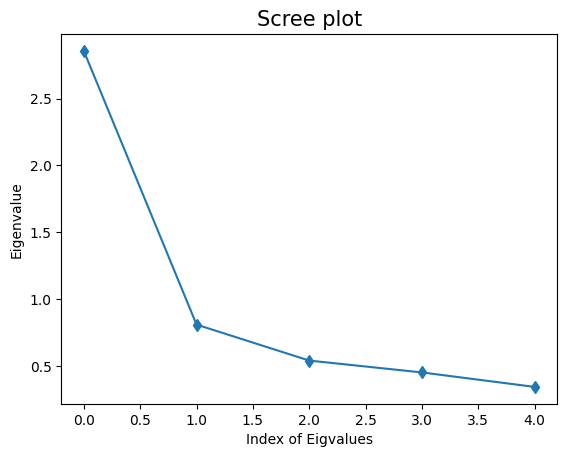

In [5]:
# 2. SCree plot 
FA.screeplot() 
# 두번째에서 elbow 나타남 -> 한개의 factor로만도 이 데이터 설명 가능

## B. How many factors are required to describe adequately the space in which these data fall?

Based on result of A, i.e. the principle analysis result and the scree plot show that the first principal component explains 57% of the total variance and the influence of other component is minor. Additionally, an elbow is observed at the second component in the scree plot. Combining these two results, it can be inferred that the correlation structure of the data can be sufficiently preserved by the first component alone.

## C. Obtain the factor loading matrix.

In [6]:
# Factor loading marix
FA.factor_loading(m=1)

,Factor1
Allied Chemical,0.78344
Du Pont,0.77251
Union Carbide,0.79432
Exxon,0.71268
Texaco,0.71209


## D. Obtain the communality of each variable.

In [7]:
# Cummunality of each variable
cummunality = pd.DataFrame(FA.communality(m=1), columns=['cummunality'])
cummunality

,cummunality
Allied Chemical,0.61377
Du Pont,0.59677
Union Carbide,0.63095
Exxon,0.50792
Texaco,0.50708


# E. Identify the underlying characteristics of each factor.

Given the high loadings for X1, X2 and X3, it suggests that 'Allied Chemical', 'Du Pont' and 'Union Carbide' can be grouped together, i.e., they share same risk in stock market. However, as there isn't much difference in the loading values for the remaining two variables, further analysis seems necessary.

----  
# Use the 'factor_analyzer' package of python to answer the questions below.

## F. Obtian the factor (before rotation) loading matrix using Minres method.

- In case of m = 1, rotation is not possible and loading matrix can not be calculated in result, so analysis is condeucted with at least two factors

In [8]:
fa = FactorAnalyzer(n_factors=2, rotation=None, is_corr_matrix=True, method='minres')
fa.fit(stock.corr())

# Factor variance
fvar = pd.DataFrame(fa.get_factor_variance()).T
fvar.index = ['Factor1', 'Factor2']
fvar.columns = ['Varriance', 'Proportion', 'Cumulative']
fvar

,Varriance,Proportion,Cumulative
Factor1,2.46267,0.49253,0.49253
Factor2,0.52796,0.10559,0.59813


In [9]:
# Factor Loadings
loadings = pd.DataFrame(fa.loadings_, 
                        index=stock.columns,
                        columns=['Factor1', 'Factor2'])
loadings

,Factor1,Factor2
Allied Chemical,0.69601,-0.09671
Du Pont,0.75858,-0.41858
Union Carbide,0.71536,-0.14635
Exxon,0.60630,0.15656
Texaco,0.72350,0.54541


## G. Obtian the factor (after rotation) loading matrix using Minres method.

#### 1) rotation matrix

In [10]:
fa = FactorAnalyzer(n_factors=2, rotation='varimax', is_corr_matrix=True, method='minres')
fa.fit(stock.corr())

# Orthogonal Transformation Matrix
fa.rotation_matrix_

array([[ 0.76844412, -0.63991689],
       [ 0.63991689,  0.76844412]])

#### 2) Loading matrix

In [11]:
# Rotated Factor Pattern
Rloadings = pd.DataFrame(fa.loadings_, 
                         index=stock.columns,
                         columns=['Factor1', 'Factor2'])
Rloadings

,Factor1,Factor2
Allied Chemical,0.59673,0.37107
Du Pont,0.85078,0.16378
Union Carbide,0.64337,0.34531
Exxon,0.36572,0.50829
Texaco,0.20695,0.88210


## H. Obtain the communalityes (after rotation) of each variable.

In [12]:
# Communality
pd.DataFrame(fa.get_communalities(), 
             index=stock.columns, 
             columns=['Communality'])

,Communality
Allied Chemical,0.49378
Du Pont,0.75065
Union Carbide,0.53316
Exxon,0.39211
Texaco,0.82093


## I. Identify the underlying characteristics of each factor

Because of the high values of factor 1 for X1 ~ X3 and the larger values of factor 2 for X4 and X5, the effects of factor 1 and factor 2 for each group of variables are significant, so it can be divided into two groups. It can be interpreted as 'Allied Chemical', 'Du Pont', 'Union Carbide' are same group that shares the same risk in the stock portfolio and applies to 'Exxon' and 'Texaco'.